In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Load the data into a DataFrame
df = pd.read_csv("validation_results.bed", sep="\t", header=None)

# Columns: chromosome, start, end, cell_line, label, score
df.columns = ["chromosome", "start", "end", "cell_line", "label", "score"]

# Remove the 'tensor()' part from 'start' and 'end' columns
df['start'] = df['start'].str.extract(r'tensor\((\d+)\)').astype(int)
df['end'] = df['end'].str.extract(r'tensor\((\d+)\)').astype(int)

df.head()

,chromosome,start,end,cell_line,label,score
0,chr1,6784295,6785437,C4-2,Negative,-0.311408
1,chr3,145903798,145904986,22Rv1,Negative,-10.096406
2,chr12,48998363,49000106,22Rv1,Negative,-12.597146
3,chr3,184007893,184008500,LNCAP,Positive,3.995975
4,chr5,1333486,1333685,22Rv1,Positive,4.369760


In [3]:
df['classified_label'] = df['score'].apply(lambda x: 'Positive' if x > 0.5 else 'Negative')

df

,chromosome,start,end,cell_line,label,score,classified_label
0,chr1,6784295,6785437,C4-2,Negative,-0.311408,Negative
1,chr3,145903798,145904986,22Rv1,Negative,-10.096406,Negative
2,chr12,48998363,49000106,22Rv1,Negative,-12.597146,Negative
3,chr3,184007893,184008500,LNCAP,Positive,3.995975,Positive
4,chr5,1333486,1333685,22Rv1,Positive,4.369760,Positive
...,...,...,...,...,...,...,...
19995,chr5,23990962,23991310,22Rv1,Positive,4.589067,Positive
19996,chr5,38466491,38467360,LNCAP,Negative,-6.769020,Negative
19997,chr1,204677669,204678779,22Rv1,Negative,-9.064239,Negative
19998,chr3,42613491,42613763,LNCAP,Negative,-6.301311,Negative


In [4]:
# Calculating accuracy: comparing the original label with the classified label
correct_predictions = (df['label'] == df['classified_label']).sum()
total_predictions = len(df)

accuracy = correct_predictions / total_predictions * 100

accuracy

86.695

In [5]:
# Splitting the dataset
below_05 = df[df['score'] < 0.5]
above_or_equal_05 = df[df['score'] >= 0.5]

# Calculating min and max for each part
min_below_05, max_below_05 = below_05['score'].min(), below_05['score'].max()
min_above_05, max_above_05 = above_or_equal_05['score'].min(), above_or_equal_05['score'].max()

# Define scaling functions
def scale_below_05(score):
    return (score - min_below_05) / (max_below_05 - min_below_05) * 0.5

def scale_above_05(score):
    return 0.5 * (score - min_above_05) / (max_above_05 - min_above_05) + 0.5

# Apply the scaling functions
df.loc[df['score'] < 0.5, 'scaled_score'] = df['score'].apply(scale_below_05)
df.loc[df['score'] >= 0.5, 'scaled_score'] = df['score'].apply(scale_above_05)

df

,chromosome,start,end,cell_line,label,score,classified_label,scaled_score
0,chr1,6784295,6785437,C4-2,Negative,-0.311408,Negative,0.475148
1,chr3,145903798,145904986,22Rv1,Negative,-10.096406,Negative,0.174876
2,chr12,48998363,49000106,22Rv1,Negative,-12.597146,Negative,0.098135
3,chr3,184007893,184008500,LNCAP,Positive,3.995975,Positive,0.662306
4,chr5,1333486,1333685,22Rv1,Positive,4.369760,Positive,0.679676
...,...,...,...,...,...,...,...,...
19995,chr5,23990962,23991310,22Rv1,Positive,4.589067,Positive,0.689867
19996,chr5,38466491,38467360,LNCAP,Negative,-6.769020,Negative,0.276983
19997,chr1,204677669,204678779,22Rv1,Negative,-9.064239,Negative,0.206550
19998,chr3,42613491,42613763,LNCAP,Negative,-6.301311,Negative,0.291336


In [6]:


# Function to calculate TP, FP, FN, TN for a group
def calculate_metrics(group):
    TP = ((group['label'] == 'Positive') & (group['classified_label'] == 'Positive')).sum()
    FP = ((group['label'] == 'Negative') & (group['classified_label'] == 'Positive')).sum()
    FN = ((group['label'] == 'Positive') & (group['classified_label'] == 'Negative')).sum()
    TN = ((group['label'] == 'Negative') & (group['classified_label'] == 'Negative')).sum()

    # Calculating Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return pd.Series({'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN, 'Precision': precision, 'Recall': recall})

# Apply the function to each cell line
metrics_by_cell_line = df.groupby('cell_line').apply(calculate_metrics)

print(metrics_by_cell_line)


               TP     FP     FN      TN  Precision    Recall
cell_line                                                   
22Rv1      4636.0  266.0  298.0  4702.0   0.945736  0.939603
A549          4.0    1.0   11.0    18.0   0.800000  0.266667
C4-2       1409.0  252.0  243.0  1425.0   0.848284  0.852906
LNCAP      2173.0  550.0  970.0  2636.0   0.798017  0.691378
MCF7         80.0    9.0   19.0   120.0   0.898876  0.808081
PC-3         19.0    7.0   11.0    31.0   0.730769  0.633333
THP-1        36.0    7.0   17.0    50.0   0.837209  0.679245


In [7]:
df

,chromosome,start,end,cell_line,label,score,classified_label,scaled_score
0,chr1,6784295,6785437,C4-2,Negative,-0.311408,Negative,0.475148
1,chr3,145903798,145904986,22Rv1,Negative,-10.096406,Negative,0.174876
2,chr12,48998363,49000106,22Rv1,Negative,-12.597146,Negative,0.098135
3,chr3,184007893,184008500,LNCAP,Positive,3.995975,Positive,0.662306
4,chr5,1333486,1333685,22Rv1,Positive,4.369760,Positive,0.679676
...,...,...,...,...,...,...,...,...
19995,chr5,23990962,23991310,22Rv1,Positive,4.589067,Positive,0.689867
19996,chr5,38466491,38467360,LNCAP,Negative,-6.769020,Negative,0.276983
19997,chr1,204677669,204678779,22Rv1,Negative,-9.064239,Negative,0.206550
19998,chr3,42613491,42613763,LNCAP,Negative,-6.301311,Negative,0.291336


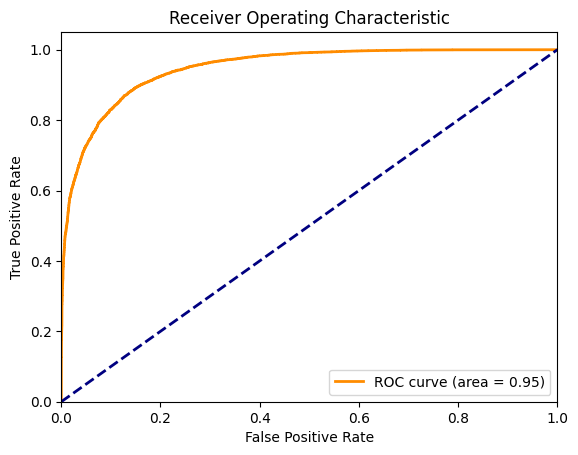

In [8]:

# Convert the 'label' column to binary format: 'Positive' to 1, 'Negative' to 0
df['binary_label'] = df['label'].map({'Positive': 1, 'Negative': 0})

# Use the scaled scores and true labels
y_true = df['binary_label']
y_scores = df['scaled_score']

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
# Path for the output BED file
output_bed_path = "processed_bed_file.bed"

# Writing the DataFrame to a BED file, excluding the 'classified_label' column
df.to_csv(output_bed_path, sep='\t', index=False, header=False)